# 04 - Applied ML

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import networkx as nx
%matplotlib inline

//anaconda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Question 1
## 1. A naive analysis

When we look at the data only using this naive approach, we can be tempted to say that this treatment has no effect.
Using the graph, we see that more people have a revenu of 0 in the treated group compared to the untreated group.

In [3]:
data = pd.read_csv('lalonde.csv')
data.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [4]:
data.head(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899
5,NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940
6,NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000
7,NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580
8,NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220
9,NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.0700


In [5]:
data['white'] = ((1-data['black']) & (1-data['hispan']))
data.head(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0
5,NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940,0
6,NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000,0
7,NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580,0
8,NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220,0
9,NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.0700,1


In [6]:
boolean_dict = {0: 'No', 1: 'Yes'}

def plot_feature(feature_name, data, plot_type):
    """Display two side by side plots (treated and untreated people) of the given feature and for the given plot type.
    
    feature_name: name of the feature to be plotted
    data: data containing the feature
    plot_type: type of plot to display. It must be either 'hist' or 'bar'
    """
    
    if plot_type is not 'hist' and plot_type is not 'bar':
        raise ValueError('plot_type must be either \'hist\' or \'bar\'')
    
    # Compute the minimum and maximum value to set the scale of the histogram
    r_min = data[feature_name].min()
    r_max = data[feature_name].max()
    
    # Separate treated and untreated people
    data_treated = data[data["treat"] == 1]
    data_untreated = data[data["treat"] == 0]
    
    # Display plots
    plt.figure(figsize=(14,4))
    plt.suptitle(feature_name, fontsize=20)
    ax = plt.subplot(1,2,1)
    plt.title("Treated people", fontsize=14)
    if plot_type is 'hist':
        plt.hist(data_treated[feature_name], normed=True, bins=40, range=(r_min, r_max))
    elif plot_type is 'bar':
        data_treated[feature_name].map(boolean_dict).value_counts().sort_index().plot(kind='bar', rot=0)
        
    plt.subplot(1,2,2, sharey=ax)
    plt.title("Untreated people", fontsize=14)
    if plot_type is 'hist':
        plt.hist(data_untreated[feature_name], normed=True, bins=40, range=(r_min, r_max))
    elif plot_type is 'bar':
        data_untreated[feature_name].map(boolean_dict).value_counts().sort_index().plot(kind='bar', rot=0)
    plt.show()

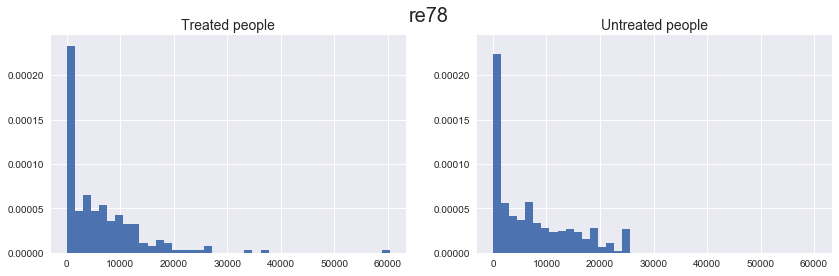

In [7]:
plot_feature('re78', data, 'hist')

## 2. A closer look at the data

What we observe with the graph below are that the population of the treatement group and the population of the untreated group is very different. For instance, in the treated group, we have a bigger proportion of black people than in the untreated group. We also have a difference in the married, re74 and re75 feature. This makes it impossible to compare results of the treatement using these two groups.

A superficial analysis cannot draw any conclusion in our case (population too differente).

In [8]:
data_features = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']
data_features.remove('re78')
data_features

['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']

In [9]:
def plot_race_bar(data):
    "Display a single bar plot showing the race of treated and untreated people."
    
    features_names = ['black', 'hispan', 'white']
    
    # Separate treated and untreated people
    data_treated = data[data["treat"] == 1]
    data_untreated = data[data["treat"] == 0]
    
    
    data_treated = data_treated[features_names].idxmax(axis=1).value_counts().sort_index()
    data_untreated = data_untreated[features_names].idxmax(axis=1).value_counts().sort_index()
    
    fig, ax = plt.subplots()
    data_treated.plot.bar(width=0.2, position=1, color='green', ax=ax, alpha=0.7, rot=0, figsize=(7,5))
    data_untreated.plot.bar(width=0.2, position=0, color='red', ax=ax, alpha=0.7, rot=0, figsize=(7,5))
    plt.legend(loc="upper center")
    plt.xticks()
    plt.xlabel("Race")
    plt.ylabel("Number of people")
    
    legend = plt.legend()
    legend.get_texts()[0].set_text('Treated')
    legend.get_texts()[1].set_text('Untreated')
    
    plt.show()

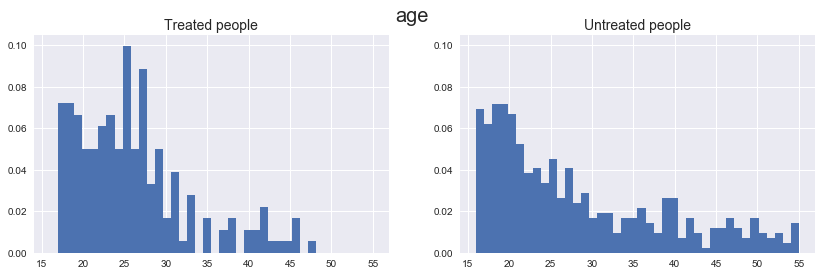

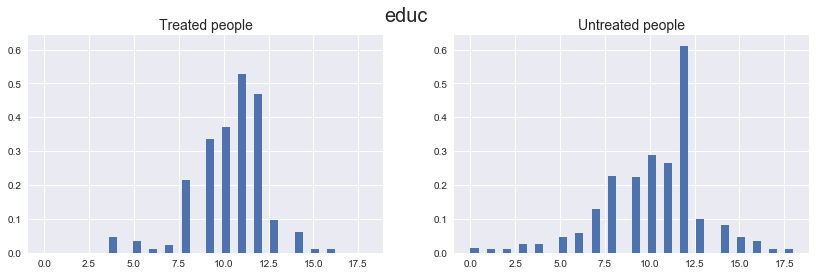

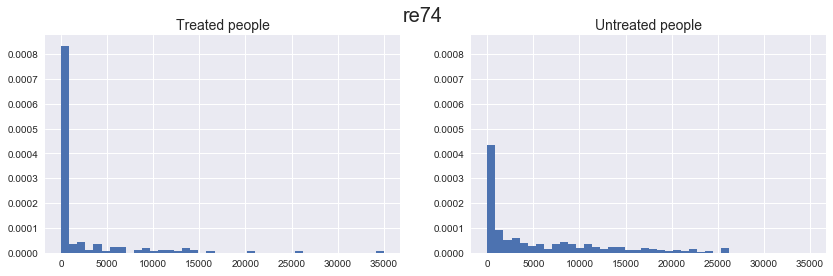

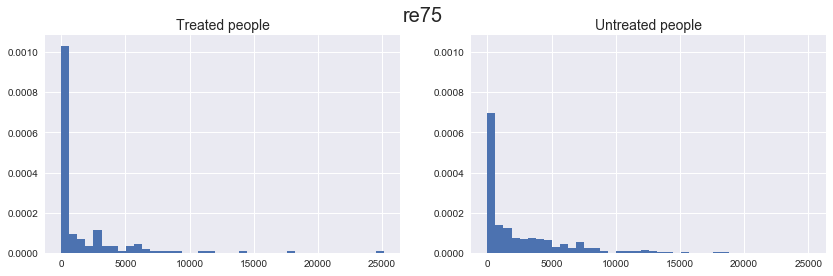

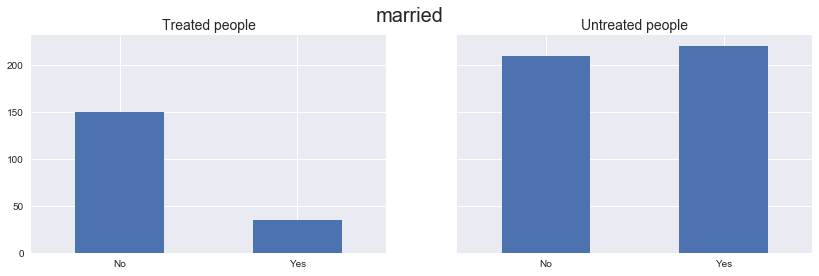

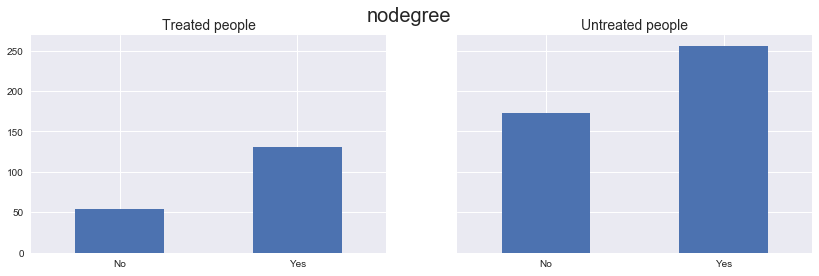

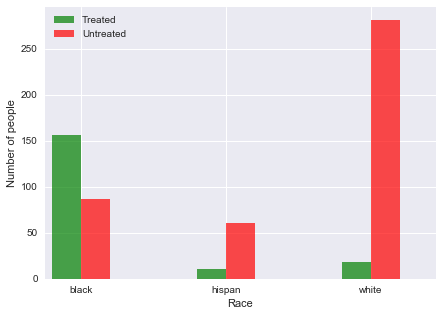

In [10]:
# Display histogram plots for non-categorical features
for col in ["age", "educ", "re74", "re75"]:
    plot_feature(col, data, 'hist')
    
# Display bar plots for categorical features
for col in ["married", "nodegree"]:
    plot_feature(col, data, 'bar')

# Display a single bar plot to show the distribution of races
plot_race_bar(data)

## 3. A propsensity score model

In [11]:
# The features vector
X = data[data_features]
# The label vector
y = data['treat']

logistic = LogisticRegression()
logistic.fit(X, y)
pred_prob = logistic.predict_proba(X)
pred_prob

array([[ 0.55664958,  0.44335042],
       [ 0.85534047,  0.14465953],
       [ 0.27764537,  0.72235463],
       ..., 
       [ 0.87687096,  0.12312904],
       [ 0.44954003,  0.55045997],
       [ 0.84497047,  0.15502953]])

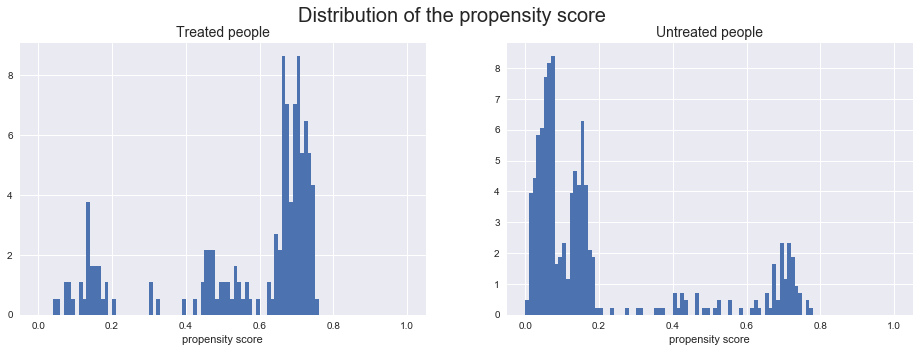

0.561869387932
0.196656023697


In [12]:
treated_idx = np.where(data['treat'] == 1)[0]
untreated_idx = np.where(data['treat'] == 0)[0]

pred_prob_treated = pred_prob[treated_idx, 1]
pred_prob_untreated = pred_prob[untreated_idx, 1]

plt.figure(figsize=(16,5))
plt.suptitle("Distribution of the propensity score", fontsize=20)
plt.subplot(1,2,1)
plt.hist(pred_prob_treated, bins=100, range=(0, 1), normed=True)
plt.xlabel('propensity score')
plt.title("Treated people", fontsize=14)

plt.subplot(1,2,2)
plt.hist(pred_prob_untreated, bins=100, range=(0, 1), normed=True)
plt.title("Untreated people", fontsize=14)
plt.xlabel('propensity score')
plt.show()

print(np.mean(pred_prob_treated))
print(np.mean(pred_prob_untreated))

## 4. Balancing the dataset via matching

For this part, our goal is to find matching pairs of a treated and untreated subjects such that the absolute propensity-score differences between the two matched subjects is minimized. As hinted in the README, the `networkx` package provides a hepful function, namely `max_weight_matching(G, maxcardinality=False)`, which computes a maximum-weighted matching of the undirected graph G. From the `networkx` documentation, we learn the following: 

> A matching is a subset of edges in which no node occurs more than once. The cardinality of a matching is the number of matched edges. The weight of a matching is the sum of the weights of its edges.

Therefore, in order to solve our problem by using this function, we must create a graph that has one node for each subject and edges from every treated subject nodes to every untreated subject nodes. With this setup, a minimum matching on this graph is equivalent to selecting a set of pairs of one treated and one untreated subject. The edges of the matching thus correspond to the selected pairs.

The last thing we have to decide is how to set the weights of the edges of our graph so that the absolute propensity-score differences between matched subjects is minimized. Since the function maximizes the weight, we set the edge weights as the the negative of the absolute propensity-score differences. We still have to set the parameter `maxcardinality` to `True` so that the maximum number of edges (i.e. subject pairs) are matched.

In [15]:
# Create the graph
G = nx.graph.Graph()
    
# Create a node for each subject
for index in data.index:
    G.add_node(index)

# Create edges between each treated and untreated subjects
for t_index in treated_idx:
    for unt_index in untreated_idx:
        # Set the weight as the absolute propensity-score difference
        abs_diff = np.abs(pred_prob[t_index, 1] - pred_prob[unt_index, 1])
        G.add_edge(t_index, unt_index, weight=abs_diff)
        
matching = nx.max_weight_matching(g, maxcardinality=True)

In [21]:
# Retrieve the ids and the data of the matched subjects
matched_idx = list(matching.keys())
matched_data = data.iloc[matched_idx,:]

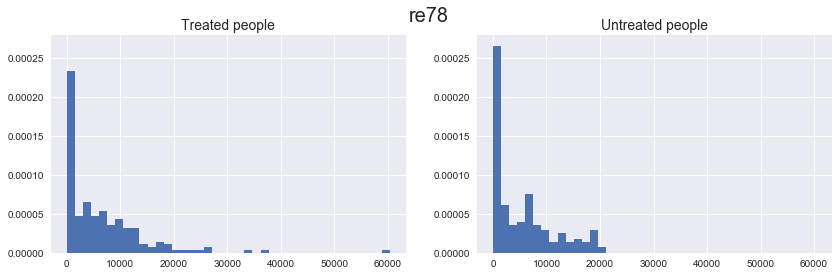

In [20]:
plot_feature("re78", matched_data, "hist")

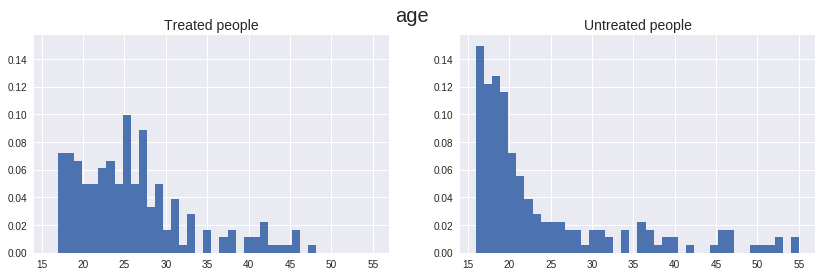

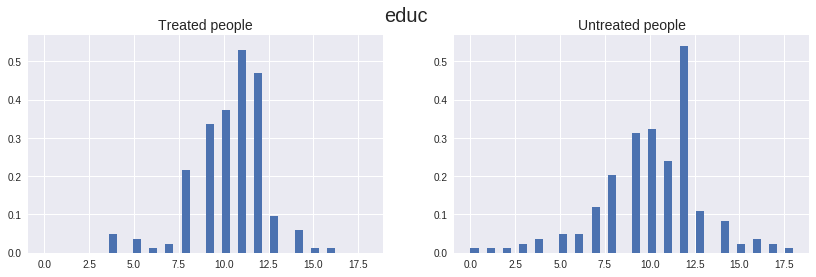

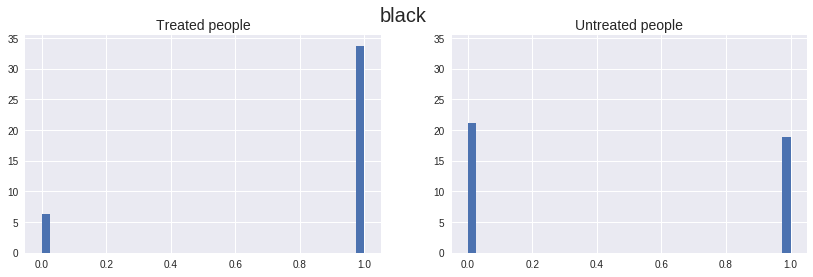

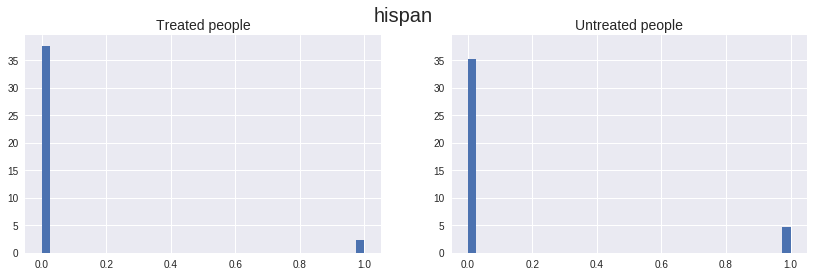

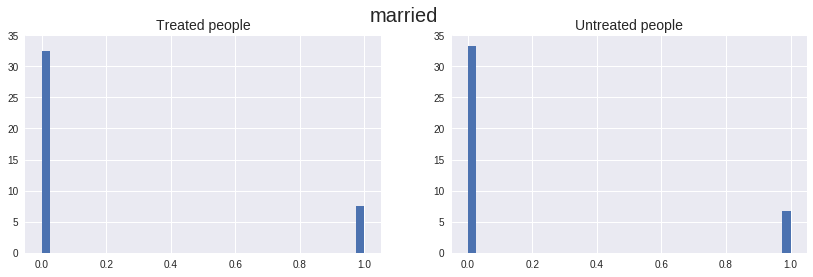

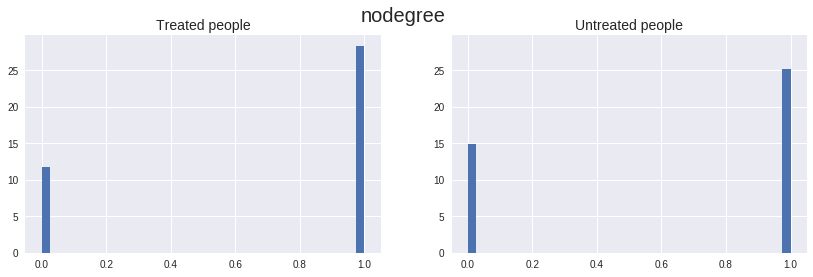

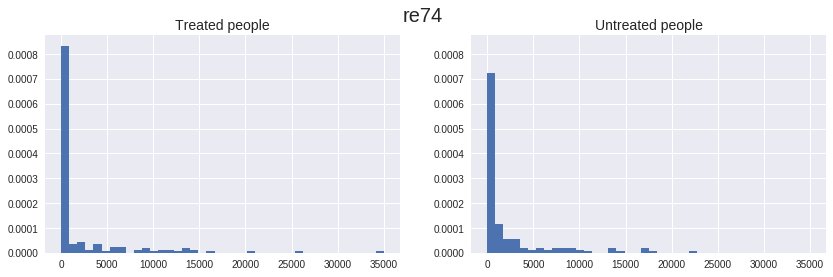

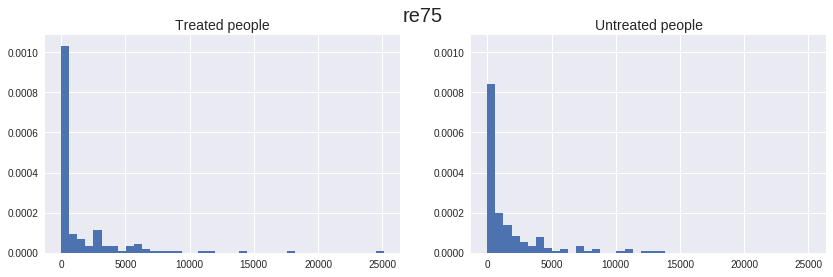

In [17]:
for col in ["age", "educ", "black", "hispan", "married", "nodegree", "re74", "re75"]:
    plot_feature(col, matched_data, "hist")

The data has a similar distribution, the treated group can now be compared with the control group.

## 5. Balancing the groups further

We notice that the black feature does not balance well enough making it diffucult to draw valid conclusion on the treatement. We will explicitly match only if this feature matches.

In [18]:
matched_data

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white
595,PSID411,0,18,10,1,0,0,1,0.0000,0.0000,5306.51600,0
24,NSW25,1,18,10,1,0,0,1,0.0000,0.0000,11163.17000,0
585,PSID401,0,17,10,1,0,0,1,0.0000,0.0000,1053.61900,0
28,NSW29,1,17,10,1,0,0,1,0.0000,0.0000,16218.04000,0
582,PSID398,0,17,8,1,0,0,1,0.0000,0.0000,4520.36600,0
42,NSW43,1,17,8,1,0,0,1,0.0000,0.0000,8061.48500,0
576,PSID392,0,17,10,1,0,0,1,0.0000,0.0000,0.00000,0
30,NSW31,1,17,10,1,0,0,1,0.0000,0.0000,0.00000,0
573,PSID389,0,18,11,1,0,0,1,0.0000,0.0000,7146.28600,0
52,NSW53,1,18,11,1,0,0,1,0.0000,0.0000,0.00000,0


## 6. A less naive analysis

# Question 2: Applied ML

In [26]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix
import itertools
newsgroups_train = fetch_20newsgroups(subset='train')

In [20]:
def split_data(x, y, ratio):
    '''
        split the dataset based on the split ratio. If ratio is 0.8,
        you will have 80% of your data set dedicated to training
        and the rest dedicated to testing
    '''
    random_uniform_vector = np.random.rand(x.shape[0])
    spliter = random_uniform_vector < ratio
    return (x[spliter == True], y[spliter == True]), (x[spliter == False], y[spliter == False])

In [21]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(newsgroups_train["data"])

(train_X, train_Y), (other_X, other_Y)  = split_data(X, newsgroups_train["target"], 0.8)
(validation_X, validation_Y), (test_X, test_Y) = split_data(other_X, other_Y, 0.5)

In [22]:
best_accuracy = 0.
best_n_est = 1
best_max_dep = 1
best_prediction = None
best_classifier = None

for n_est in range(5, 30, 5):
    for max_dep in range(20, 100, 10):
        print("doing : (%s, %s)" % (n_est, max_dep), end="\r")
        classifier = RandomForestClassifier(n_estimators=50, max_depth=100)
        classifier.fit(train_X, train_Y)
        
        prediction = classifier.predict(validation_X)
        accuracy = (len(prediction) - np.count_nonzero(prediction - validation_Y)) / len(prediction)
        
        if accuracy > best_accuracy:
            print("best accuracy : %s" % accuracy)
            best_accuracy = accuracy
            best_n_est = n_est
            best_max_dep = max_dep
            best_prediction = prediction
            best_classifier = classifier

best accuracy : 0.8111587982832618
best accuracy : 0.8231759656652361
best accuracy : 0.8257510729613734


Here we see that the importance of most feature is 0.
Then only a little fraction of the remaining importances is big (shown in the graph).

non zero importance count : 25695
zero importance count : 104412


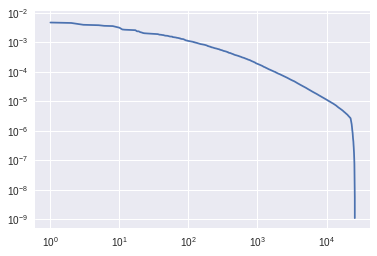

In [23]:
non_zero_importance_count = np.count_nonzero(best_classifier.feature_importances_)
zero_importance_count = best_classifier.feature_importances_.shape[0] - non_zero_importance_count

print("non zero importance count : %s" % non_zero_importance_count)
print("zero importance count : %s" % zero_importance_count)

non_zero_indices = np.nonzero(best_classifier.feature_importances_)
plt.plot(range(non_zero_importance_count), np.sort(best_classifier.feature_importances_[non_zero_indices])[::-1])
plt.loglog()
plt.show()

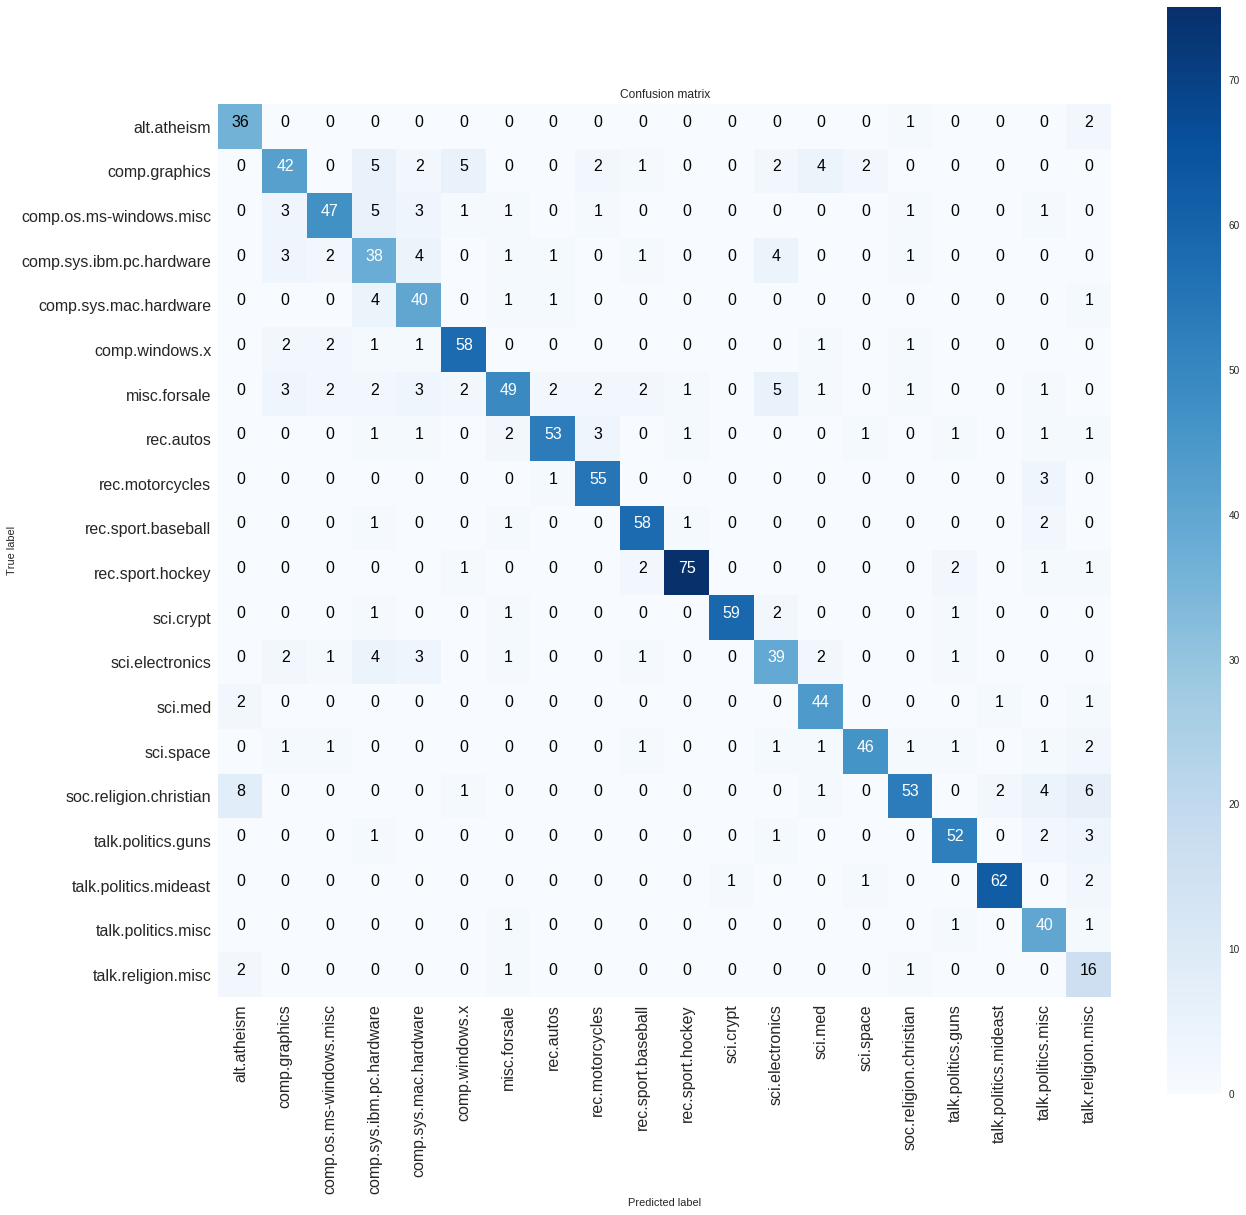

In [28]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
    """
    plt.rcParams["axes.grid"] = False
    plt.figure(figsize=(20, 20))
    
    plt.imshow(cm, cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    legend_marks = np.arange(len(classes))
    plt.xticks(legend_marks, classes, fontsize=16, rotation=90)
    plt.yticks(legend_marks, classes, fontsize=16)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=16)


plot_confusion_matrix(confusion_matrix(best_prediction, validation_Y), newsgroups_train.target_names)